## Anomaly Detection

 I will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected  examples of how they were behaving, and thus have an unlabeled dataset {x<sup>(1)</sup>,x<sup>(2)</sup>,.... x<sup>(m)</sup>}. You suspect that the vast majority of these examples are 'normal' (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

In [1]:
import pandas as pd              # dataframe library
import matplotlib.pyplot as plt  # ploting library
import numpy as np  # N- dim object array 
import scipy.io 

# inline plotting of graphs
%matplotlib inline

#### Load and Review Data

In [2]:
df = pd.read_csv("./data1.csv")

 **The first the 2 columns represent the features, i.e., Latency and Throughput.<br>
 The next two columns represnet the validation set's features.**

In [3]:
df.shape

(307, 5)

In [4]:
df.head(5)

,X1,X2,X3,X4,Y
0,13.046815,14.741152,15.790260,14.921024,0
1,13.408520,13.763270,13.639619,15.329955,0
2,14.195915,15.853181,14.865899,16.473865,0
3,14.914701,16.174260,13.584676,13.989306,0
4,13.576700,14.042849,13.464042,15.635330,0


The X1 and X2 are features for the data set. <br>
The X3 and X4 are features for the validation set.<br>
The last column determines the anomaly identification.

#### Plotting the features

Text(0, 0.5, 'Throughput (mb/s)')

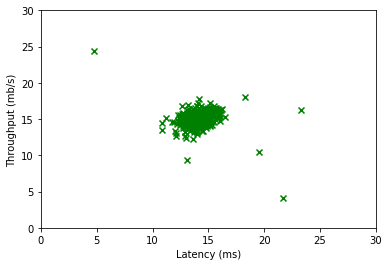

In [5]:
X = np.array(df[["X1","X2"]])
Xval = np.array(df[["X3","X4"]])
Y = np.array(df["Y"])

plt.figure(figsize=(6,4))
plt.scatter(X[:,0],X[:,1], marker="x",color='green')
plt.axis((0,30,0,30))
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

In [6]:
def Gaussian(X):
    n = np.size(X, 1)
    m = np.size(X, 0)
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))

    mu = np.reshape((1/m)*np.sum(X, 0), (1, n))
    sigma2 = np.reshape((1/m)*np.sum(np.power((X - mu),2), 0),(1, n))

    return mu, sigma2

In [7]:
mu , sigma2 = Gaussian(X)

In [8]:
def MultiVariantGaussian(X,mu,sigma2):
    n = np.size(sigma2, 1)
    m = np.size(sigma2, 0)
     
    if n == 1 or m == 1:
        sigma2 = np.diag(sigma2[0,:])
    row_size = np.size(X, 0)
   
    mu = np.tile(mu,(row_size,1))
    X = X - mu
    pi = np.pi
    det = np.linalg.det(sigma2)
    inv = np.linalg.inv(sigma2)
    val = (-0.5)*np.sum(np.multiply((X@inv),X), 1)
    p = np.power(2*pi, -n/2)*np.power(det, -0.5)*np.exp(val)

    return p

In [9]:
def VisualizetheFit(X,mu,sigma2,epsilon = 0):
    x = np.arange(0,35.5,0.5)
    X1,X2 = np.meshgrid(x,x)
    Z = MultiVariantGaussian(np.column_stack([X1.flatten(),X2.flatten()]),mu,sigma2)
    Z = np.reshape(Z,X1.shape)
    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0],X[:,1],marker="x",color='green')
    if (np.sum(np.isinf(Z)) == 0):
        b = np.transpose(np.arange(-20.0,0.0,3.0))
        plt.contour(X1,X2,Z,np.power(10,b),colors = 'b')
        if epsilon != 0 :
            plt.contour(X1,X2,Z,levels = [epsilon],colors = 'k',linestyles= "dashed")
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughput (mb/s)")
    

#### Using Multivariant Gaussian to form the contours.

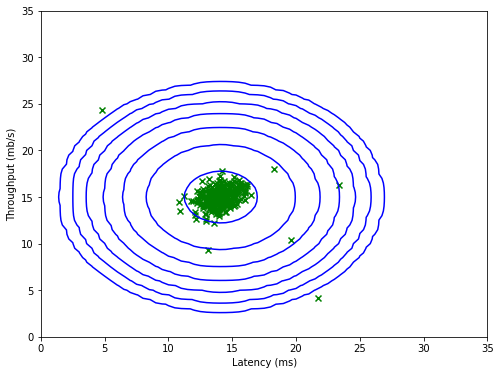

In [10]:
p = MultiVariantGaussian(X, mu, sigma2);
# Visualize the fit
VisualizetheFit(X,  mu, sigma2);

### Selecting the Threshold

**Here the threshold we would chose is by comparing the F1 score on the validation set.** <br> 
Before that we create the  multivariant gaussian for Validation set.

In [11]:
pval = MultiVariantGaussian(Xval, mu, sigma2)    

In [12]:
def selectThreshold(Y,pval):
    bestEpsilon,bestF1 = 0,0
    max_ = max(pval)
    min_ = min(pval)
    stepsize = (max_ - min_ )/1000
    epir = np.arange(min_,max_,stepsize)
    for epsilon in epir:
        predictions = (pval<epsilon)[:,np.newaxis]
        tp = np.sum(predictions[Y==1]==1)
        fp = np.sum(predictions[Y==0]==1)
        fn = np.sum(predictions[Y==1]==0)
        # compute precision, recall and F1
        if tp + fp == 0:
            continue
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        F1 = (2*prec*rec)/(prec+rec)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
            
    return bestEpsilon,bestF1
            

**Finding the best threshold and F1 score**

In [13]:
epsilon, F1 = selectThreshold(Y, pval)
print("Best epsilon found using cross-validation:",epsilon)
print("Best F1 on Cross Validation Set:",F1)

Best epsilon found using cross-validation: 8.990852779404715e-05
Best F1 on Cross Validation Set: 0.8750000000000001


**We use this threshold to mark the anamolities in the orginal data set**

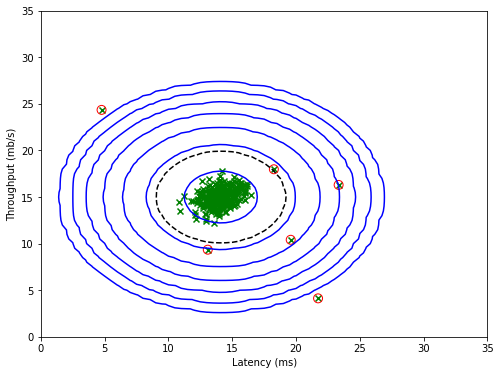

In [14]:
outliers = np.nonzero(p<epsilon)[0]
VisualizetheFit(X,  mu, sigma2,epsilon);
plt.scatter(X[outliers,0],X[outliers,1],marker ="o",facecolor="none",color="red",s=80)
plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

#### Now we will perform this on a more realistic data with 11 features capturing the properties of the servers

In [15]:
data = scipy.io.loadmat("data2.mat")


In [16]:
X = np.array(data["X"])
Xval = np.array(data["Xval"])
Y = np.array(data["yval"])

In [17]:
mu, sigma2 = Gaussian(X)
p = MultiVariantGaussian(X, mu, sigma2)
pval = MultiVariantGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(Y, pval)
print("Best epsilon found using cross-validation:",epsilon)
print("Best F1 on Cross Validation Set:",F1)
print("Outliers found:",np.sum(p<epsilon))

Best epsilon found using cross-validation: 1.3772288907613575e-18
Best F1 on Cross Validation Set: 0.6153846153846154
Outliers found: 117
